In [1]:
import os
import pandas as pd
from dotenv import load_dotenv
from pymongo import MongoClient


In [2]:

load_dotenv('../.env')
user = os.getenv("MONGODB_USER")
pwd = os.getenv("MONGODB_PWD")
host = os.getenv("MONGODB_HOST")
port = os.getenv("MONGODB_PORT")


client = MongoClient(f'mongodb://{user}:{pwd}@{host}:{port}')
db = client.test_db
display(client.list_database_names())
display(db.list_collection_names())

['admin', 'config', 'index_check', 'local', 'test_db']

['USDT-ETH', 'fred', 'USDT-BTC', 'news']

In [3]:

eth_df = pd.DataFrame(list(db['USDT-ETH'].find({})))
btc_df = pd.DataFrame(list(db['USDT-BTC'].find({})))
fred_df = pd.DataFrame(list(db['fred'].find({})))


In [4]:
client.close()

In [5]:
fred_df.head()

,_id,T5YIE,T5YIFR,T10YIE,T10Y2Y,SP500,DJIA,etz_time
0,62e1f5f9b451da94428d02ac,1.68,1.86,1.77,0.34,3230.78,28538.44,2019-12-31 23:59:00
1,62e1f60287defd03e3f2b514,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-01 23:59:00
2,62e1f60ba8ff3f491e99d07f,1.72,1.88,1.80,0.30,3257.85,28868.80,2020-01-02 23:59:00
3,62e1f6130b3f3cc52b8c1b90,1.69,1.85,1.77,0.27,3234.85,28634.88,2020-01-03 23:59:00
4,62e1f61c2b3bf67a1a736ce3,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-04 23:59:00


## missing 데이터 확인

In [6]:

def check_missing(df:pd.DataFrame, time_col:str , freq:str):
    """ check if data has missing rows
    Args:
        time_col: 'etz_time', 'utc_time'
        freq: '1H', '1D'
    """
    min_time = df[time_col].min()
    max_time = df[time_col].max()
    date_index = pd.date_range(start=min_time,
                               end=max_time, freq=freq)
    print("데이터 시간 범위", end=': ')
    print(date_index[0], date_index[-1])
    print("데이터 시간 범위", end=': ')
    print(min_time, max_time)
    print(len(date_index), len(df))
    assert len(date_index) == len(df)
    


In [7]:
check_missing(btc_df, 'utc_time', '1H')

데이터 시간 범위: 2020-01-01 00:00:00 2022-07-28 13:00:00
데이터 시간 범위: 2020-01-01 00:00:00 2022-07-28 13:00:00
22550 22550


In [8]:
check_missing(eth_df, 'utc_time', '1H')

데이터 시간 범위: 2020-01-01 00:00:00 2022-07-28 13:00:00
데이터 시간 범위: 2020-01-01 00:00:00 2022-07-28 13:00:00
22550 22550


In [9]:
check_missing(fred_df, 'etz_time', '1D')

데이터 시간 범위: 2019-12-31 23:59:00 2022-07-26 23:59:00
데이터 시간 범위: 2019-12-31 23:59:00 2022-07-26 23:59:00
939 939


## Summer time 적용하지 않은 est 시간 적용

In [10]:
import datetime as dt

In [11]:
def make_etz_time(df: pd.DataFrame, utc_col:str='utc_time', new_col:str='etz_time', time_diff = -5):
    df[new_col] = df[utc_col] + dt.timedelta(hours=time_diff)
    return df
    
btc_df = make_etz_time(btc_df)
eth_df = make_etz_time(eth_df)




## 서버 점검시간 & 누락 데이터 확인 확인

In [23]:
btc_df = btc_df.sort_values('utc_time')
eth_df = eth_df.sort_values('utc_time')

In [37]:
def check_server_maintenance_time(df):
    df = df[df.candle_date_time_utc != df.utc_time - dt.timedelta(hours=1)]
    return df
    
missing_btc_df = check_server_maintenance_time(btc_df)
missing_eth_df = check_server_maintenance_time(eth_df)

print(f"점검시간 비율: {len(missing_btc_df) / len(btc_df):.4f}")
print(f"점검시간 비율: {len(missing_eth_df) / len(eth_df):.4f}")


점검시간 비율: 0.1202
점검시간 비율: 0.3753


## 일단위 데이터로 groupby
- opening_price	시가	Double
- high_price	고가	Double
- low_price	저가	Double
- trade_price	종가	Double
- candle_acc_trade_price	누적 거래 금액	Double
- candle_acc_trade_volume	누적 거래량	Double

In [44]:
consider_cols = ["opening_price", # take fist
                "high_price",  # max
                "low_price",   # min
                "trade_price", # take last
                "candle_acc_trade_price", # sum
                "candle_acc_trade_volume"] # sum

In [70]:

btc_df['etz_date'] = btc_df['etz_time'].apply(lambda x: x.date())
conditions = {"opening_price": "first",
            "high_price": "max", 
            "low_price": "min",  
            "trade_price": "last",
            "candle_acc_trade_price": "sum",
            "candle_acc_trade_volume": "sum"
}

daily_btc_df = btc_df.groupby('etz_date').agg(conditions)

In [71]:
daily_btc_df.head()

,opening_price,high_price,low_price,trade_price,candle_acc_trade_price,candle_acc_trade_volume
etz_date,,,,,,
2019-12-31,7440.0,7440.000000,7420.000,7420.0,65.363881,0.008798
2020-01-01,7420.0,7480.000000,6900.000,7385.0,17619.151538,2.473489
2020-01-02,7345.0,7435.000000,6999.999,7145.0,11756.343703,1.640328
2020-01-03,7170.0,7649.999998,7170.000,7505.0,12236.129466,1.671004
2020-01-04,7325.0,7643.000000,7325.000,7643.0,4375.350268,0.578996


<AxesSubplot:xlabel='etz_date'>

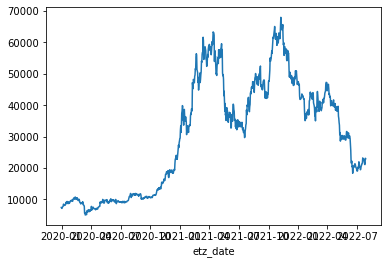

In [73]:
daily_btc_df.trade_price.plot()